In [14]:
import donkeycar as dk

from PIL import Image
import os
import numpy as np

In [3]:
%matplotlib inline
import pandas as pd

In [57]:
tub_path = '/home/wroscoe/d2/data/diy_1/'
T = dk.parts.Tub(path=tub_path)
T.get_json_record(3)

Tub does exist


{'cam/image_array': '3_cam-image_array_.jpg',
 'user/angle': -0.141705766475975,
 'user/mode': 'user',
 'user/throttle': 0.5069282409952348}

## Shift records forward.

In [12]:
df = pd.DataFrame([T.get_json_record(i) for i in T.get_index(shuffled=False)])
#df['user/angle'] = df['user/angle'].shift(-10)
df = df.dropna()

In [103]:
import random

In [104]:
index = list(df.index)
random.shuffle(index)

In [124]:
def get_record_from_df(df, data_path, record_transform=None, shuffle=False):
    
    index = list(df.index)
    if shuffle:
        random.shuffle(index)
    while True:
        for i in index:
            row = dict(df.ix[i])
            img = Image.open(os.path.join(data_path, row['cam/image_array']))
            row['cam/image_array'] = np.array(img)
            if record_transform:
                row = record_transform(row)
            yield row

    
def get_batch_from_df(keys, df, record_transform=None, batch_size=128,
                      record_tranform=None, data_path=None, shuffle=False):
    
    record_gen = get_record_from_df(df, data_path, record_transform, shuffle=shuffle)
    
    if keys==None:
        keys = list(df.columns)
    while True:
        record_list = []
        for _ in range(batch_size):
            record_list.append(next(record_gen))

        batch_arrays = {}
        for i, k in enumerate(keys):
            arr = np.array([r[k] for r in record_list])
            #if len(arr.shape) == 1:
            #    arr = arr.reshape(arr.shape + (1,))
            batch_arrays[k] = arr

        yield batch_arrays
        
def train_gen(X_keys, Y_keys, df, batch_size=128, data_path=None, 
              record_transform=None):
    
    batch_gen = get_batch_from_df(X_keys+Y_keys, df, batch_size=128, record_transform=None, 
                                  data_path=data_path)
    while True:
        batch = next(batch_gen)
        X = [batch[k] for k in X_keys]
        Y = [batch[k] for k in Y_keys]
        yield X,Y
        
        

In [106]:
cutoff = int(len(df)*.8//1)

In [107]:
tt = T.train_gen(['cam/image_array'], ['user/angle', 'user/throttle'])


In [108]:
t = train_gen(['cam/image_array'], ['user/angle', 'user/throttle'], df[:cutoff], batch_size=128, data_path=T.path)
v = train_gen(['cam/image_array'], ['user/angle', 'user/throttle'], df[cutoff:], batch_size=128, data_path=T.path)

In [117]:
m = dk.parts.ml.keras.default_linear()

In [118]:
hist = m.fit_generator(
                t, 
                steps_per_epoch=100, 
                epochs=10, 
                verbose=1, 
                validation_data=v,
                validation_steps=1)

Epoch 1/10
100/100 [==============================] - 157s - loss: 900.3821 - angle_out_loss: 1000.3857 - throttle_out_loss: 35.0489 - val_loss: 0.0359 - val_angle_out_loss: 0.0395 - val_throttle_out_loss: 0.3626
Epoch 2/10
100/100 [==============================] - 177s - loss: 0.0408 - angle_out_loss: 0.0451 - throttle_out_loss: 0.2347 - val_loss: 0.0261 - val_angle_out_loss: 0.0287 - val_throttle_out_loss: 0.1993
Epoch 3/10
100/100 [==============================] - 174s - loss: 0.0403 - angle_out_loss: 0.0446 - throttle_out_loss: 0.1099 - val_loss: 0.0576 - val_angle_out_loss: 0.0639 - val_throttle_out_loss: 0.0614
Epoch 4/10
100/100 [==============================] - 170s - loss: 0.0327 - angle_out_loss: 0.0362 - throttle_out_loss: 0.0763 - val_loss: 0.0384 - val_angle_out_loss: 0.0426 - val_throttle_out_loss: 0.0246
Epoch 5/10
100/100 [==============================] - 159s - loss: 0.0177 - angle_out_loss: 0.0197 - throttle_out_loss: 0.0173 - val_loss: 0.0155 - val_angle_out_loss

In [125]:
img_gen = get_batch_from_df(['cam/image_array'], df, batch_size=len(df), data_path=tub_path)
img = next(img_gen)

In [126]:
img['cam/image_array'].shape

(5652, 120, 160, 3)

In [127]:
predictions = m.predict(img['cam/image_array'])

In [128]:
df['pilot/angle'] = predictions[0]

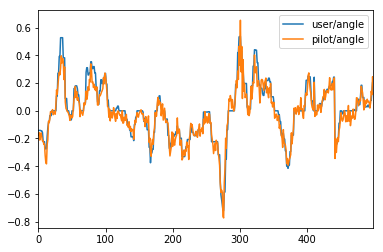

In [129]:
df[['user/angle', 'pilot/angle']][:500].plot()

In [136]:
m = keras.models.load_model('/home/wroscoe/d2/models/diy_lin_1250')

In [144]:
result = m.predict(r[0])
#np.argmax(result[0], axis=1)
result

[array([[-0.04507893],
        [-0.00287324],
        [-0.06904186],
        [-0.00423036],
        [-0.00325876],
        [-0.02970172],
        [-0.02447423],
        [-0.02693687],
        [-0.02493166],
        [-0.03716014],
        [-0.00582808],
        [-0.08257235],
        [-0.05419559],
        [-0.01814637],
        [-0.05955185],
        [-0.03689044],
        [-0.05757111],
        [-0.05949275],
        [ 0.01716883],
        [-0.03822539],
        [-0.14090078],
        [-0.04362478],
        [ 0.02009978],
        [-0.18130453],
        [-0.40281731],
        [-0.41715845],
        [-0.38310999],
        [-0.2565136 ],
        [-0.14606544],
        [-0.34517416],
        [-0.20033343],
        [-0.10754998],
        [-0.00058938],
        [-0.06935023],
        [-0.1407312 ],
        [-0.15278848],
        [-0.22463991],
        [-0.2109777 ],
        [-0.17666306],
        [-0.33965462],
        [-0.26438865],
        [-0.29222444],
        [-0.30108306],
        [-0

In [128]:
dfpd.DataFrame(result[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.002889,0.000262,0.000113,0.000332,0.000874,0.013362,0.026816,0.464476,0.392945,0.072178,0.004416,0.015483,0.000817,0.003132,0.001904
1,0.001209,0.000249,0.000178,0.000570,0.002753,0.035972,0.037394,0.764745,0.091403,0.034134,0.012069,0.016184,0.001231,0.001560,0.000347
2,0.001463,0.000650,0.001440,0.002801,0.021948,0.214341,0.151857,0.482169,0.079550,0.009009,0.016031,0.010532,0.002127,0.005760,0.000323
3,0.000915,0.000262,0.000964,0.002737,0.009546,0.124081,0.133722,0.593238,0.094084,0.010174,0.009126,0.014326,0.000958,0.005399,0.000468
4,0.001300,0.000263,0.000845,0.002270,0.002880,0.043798,0.049535,0.629151,0.168599,0.043498,0.010348,0.040579,0.001812,0.004121,0.001000
5,0.003215,0.001923,0.002388,0.003413,0.005225,0.066776,0.086268,0.545950,0.132445,0.068370,0.016058,0.051442,0.005756,0.007596,0.003174
6,0.002994,0.000972,0.002336,0.003231,0.007752,0.049721,0.055319,0.592422,0.157993,0.051747,0.022557,0.043084,0.003378,0.004385,0.002109
7,0.003869,0.001024,0.001581,0.003344,0.004220,0.018234,0.032417,0.581289,0.203282,0.073275,0.022607,0.045145,0.002617,0.004343,0.002753
8,0.002422,0.002358,0.004797,0.003065,0.013478,0.049664,0.064920,0.568712,0.161477,0.042030,0.046157,0.021328,0.007322,0.008043,0.004228
9,0.000937,0.001034,0.000557,0.000883,0.002400,0.013187,0.026888,0.710773,0.172089,0.027989,0.017082,0.017026,0.002443,0.004691,0.002018


In [111]:
r = next(t)
r[1]

[array([-0.53430105, -0.59176575, -0.76506821, -0.76506821, -0.76506821,
        -0.82727325, -0.76427716, -0.76427716, -0.64376723, -0.5229167 ,
        -0.5229167 , -0.5229167 , -0.43492736, -0.40313842, -0.40809833,
        -0.40809833, -0.28951139, -0.22236469, -0.22236469, -0.24343892,
        -0.24343892, -0.2272934 , -0.2272934 , -0.16265476, -0.2345496 ,
        -0.2345496 , -0.2345496 , -0.37286782, -0.34749746, -0.34749746,
        -0.29982846, -0.29982846, -0.2379019 , -0.2379019 , -0.2287211 ,
        -0.22863048, -0.22863048, -0.22863048, -0.2451124 , -0.20696927,
        -0.14535472, -0.14535472, -0.14535472, -0.0536792 , -0.00945108,
        -0.00945108,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.0017335 ,  0.0017335 ,
         0.1791818 ,  0.33618481,  0.33618481,  0.49266367,  0.49266367,
         0.62431059,  0.62431059,  0.66889275,  0.6

In [80]:
r get_record_from_df(3, df)

{'cam/image_array': array([[[192, 156, 106],
         [196, 160, 108],
         [200, 167, 114],
         ..., 
         [199, 148,  91],
         [195, 144,  87],
         [187, 136,  79]],
 
        [[188, 147, 101],
         [205, 164, 118],
         [195, 157, 108],
         ..., 
         [199, 148,  91],
         [195, 144,  87],
         [187, 136,  79]],
 
        [[187, 139, 101],
         [202, 154, 114],
         [197, 150, 108],
         ..., 
         [199, 148,  91],
         [194, 143,  86],
         [187, 136,  79]],
 
        ..., 
        [[ 71,  26,   7],
         [ 83,  34,  17],
         [ 97,  44,  28],
         ..., 
         [ 46,  18,   4],
         [ 42,  14,   2],
         [ 35,   7,   0]],
 
        [[ 65,  22,   3],
         [ 83,  38,  19],
         [ 94,  45,  28],
         ..., 
         [ 46,  18,   4],
         [ 41,  13,   1],
         [ 34,   6,   0]],
 
        [[ 62,  21,   1],
         [ 82,  39,  20],
         [ 92,  45,  27],
         ..., 
    

In [45]:
def get_record(ix, T):
    pass
    
T.path

'/home/wroscoe/d2/data/tub_55_17-09-16/'

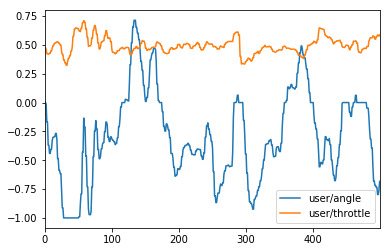

In [22]:
df[['user/angle', 'user/throttle']][0:500].plot()

In [35]:
df['pilot/throttle'] = (1-abs(df['user/angle']))/4 + .38

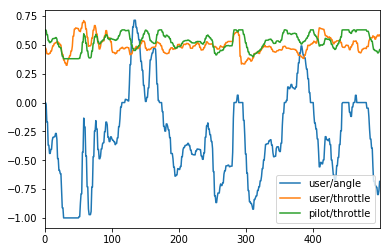

In [36]:
df[['user/angle', 'user/throttle', 'pilot/throttle']][0:500].plot()